# Load Results


In [1]:
import os
import re
import numpy as np

class SCPInstance:
    def __init__(self, index, folder="SCP-Instances", sol_file="Solutions.txt"):
        self.folder = folder
        self.sol_file = sol_file
        self.index = index

        self.filename = self._get_filename(index)
        self.name = self.filename.replace(".txt", "")

        self.path = os.path.join(folder, self.filename)

        self.m, self.n, self.costs, self.attr_of_set, self.sets_of_attr = self._load_instance()
        self.opt_value = self._load_opt_value()

    def _get_filename(self, index):
        """
        Get the filename of the SCP instance based on the index.
        """
        files = sorted(
            [f for f in os.listdir(self.folder)
             if f.lower().startswith("scp") and f.lower().endswith(".txt")]
        )
        if not files:
            raise FileNotFoundError(f"No SCP files found in {self.folder}.")
        if isinstance(index, int):
            if index >= len(files):
                raise IndexError(f"Index {index} out of range (found {len(files)} files).")
            filename = files[index]
        else:
            raise TypeError("Index must be an integer.")
        return filename

    def _load_instance(self):
        """
        Load SCP instance from file.
        """
        with open(self.path, "r") as f:
            data = list(map(int, f.read().split()))

        m, n = data[0], data[1]
        costs = data[2:2 + n]

        attr_of_set = [set() for _ in range(n)]
        sets_of_attr = [set() for _ in range(m)]

        idx = 2 + n
        for attr in range(m):
            k_i = data[idx]
            idx += 1
            airplanes = data[idx:idx + k_i]
            idx += k_i
            for j in airplanes:
                attr_of_set[j - 1].add(attr)
                sets_of_attr[attr].add(j - 1)

        return m, n, costs, attr_of_set, sets_of_attr



    def _load_opt_value(self):
        """
        Load known optimal value from solutions file.
        """
        base = self.filename.lower().replace("scp", "").replace(".txt", "")
        sol_id = f"{base[0].upper()}.{base[1:]}" if base[0].isalpha() else f"{base[0]}.{base[1:]}"
        opt_value = None

        if os.path.exists(self.sol_file):
            with open(self.sol_file, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 2 and parts[0].upper() == sol_id:
                        opt_value = float(parts[1])
                        break
        else:
            print(f"⚠️ Solutions file '{self.sol_file}' not found in current directory.")

        return opt_value
    

    def summary(self, max_show=4):
        """
        Print a summary of the SCP instance.
        """
        print("=" * 70)
        print(f"📘 Instance: {self.filename}")
        print(f"  Attributes (m): {self.m}")
        print(f"  Airplanes (n):  {self.n}")
        print(f"  Known optimal cost: {self.opt_value if self.opt_value else 'Unknown'}")
        print("Costs sample:\n", self.costs[:6], "..." if len(self.costs) > 10 else "")
        print("Example coverage:")
        for i in range(min(max_show, self.m)):
            print(f"  Attribute {i}: covered by {list(self.sets_of_attr[i])[:8]}")
        print("Example airplane coverage:")
        for j in range(min(max_show, self.n)):
            print(f"  Airplane {j}: covers {list(self.attr_of_set[j])[:8]}")
        print("=" * 70)

import os
import pandas as pd
import numpy as np

def load_results(csv_filename, results_folder="results", instances_folder="SCP-Instances", verbose=True):
    """
    Load and summarize a results CSV file for the Set Covering Problem (SCP).

    The function provides descriptive statistics for deviations from
    the best-known solutions and for computational time. It also verifies
    cost consistency and reports how many instances reached the best-known
    (optimal) value.

    Parameters
    ----------
    csv_filename : str
        Name of the results CSV file (inside results_folder).
    results_folder : str
        Directory containing the results CSVs.
    instances_folder : str
        Directory containing SCP instance files.
    verbose : bool
        If True, print a detailed summary report.

    Returns
    -------
    pd.DataFrame
        The loaded results DataFrame.
    """
    csv_path = os.path.join(results_folder, csv_filename)
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Results file not found: {csv_path}")

    df = pd.read_csv(csv_path)

    if df.empty:
        print(f"The file '{csv_filename}' is empty.")
        return df

    # Extract metrics
    devs = df["deviation_%"].dropna().to_numpy() if "deviation_%" in df else None
    times = df["time_sec"].dropna().to_numpy() if "time_sec" in df else None

    if verbose:
        print(f"\nResults summary for '{csv_filename}'")
        print("-" * 70)

        if devs is not None and len(devs):
            best_known = np.sum(np.isclose(devs, 0.0, atol=1e-6))
            print("Deviation from best-known solutions:")
            print(f"   Best deviation:   {np.min(devs):+.2f}%")
            print(f"   Average deviation: {np.mean(devs):+.2f}%")
            print(f"   Worst deviation:  {np.max(devs):+.2f}%")
            print(f"   Instances reaching best-known solution: {best_known} / {len(devs)}")

        if times is not None and len(times):
            total_seconds = np.sum(times)
            hours = int(total_seconds // 3600)
            minutes = int((total_seconds % 3600) // 60)
            seconds = int(total_seconds % 60)
            print("\nComputation time:")
            print(f"   Total runtime: {hours} h {minutes} m {seconds} s")
            print(f"   Average per instance: {np.mean(times):.2f} s")

    # Consistency check
    mismatched = 0
    if "solution_sets" in df.columns and "solution_cost" in df.columns:
        for _, row in df.iterrows():
            name = row["instance_name"]
            try:
                inst = SCPInstance(
                    sorted(os.listdir(instances_folder)).index(f"{name}.txt"),
                    folder=instances_folder
                )
            except Exception:
                continue

            raw = str(row["solution_sets"]).strip("[] ")
            if not raw:
                continue
            try:
                selected = [int(x) for x in raw.split(",") if x.strip()]
            except ValueError:
                mismatched += 1
                continue

            real_cost = sum(inst.costs[i] for i in selected)
            if abs(real_cost - row["solution_cost"]) > 1e-6:
                mismatched += 1

    if mismatched:
        print(f"\nWarning: {mismatched} solution rows contain inconsistent cost values.")
    else:
        print("\nAll solution costs verified successfully.")

    print("-" * 70)
    return df


# CH 

In [5]:
# ============================================================
# 🎨 Quartile Comparison — Constructive Heuristics (Horizontal Layout, Enlarged)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# --- Combine relevant columns into one DataFrame ---
data = pd.DataFrame({
    "CH1": df_ch1["deviation_%"].dropna(),
    "CH1 + RE": df_ch1_re["deviation_%"].dropna(),
    "CH2": df_ch2["deviation_%"].dropna(),
    "CH2 + RE": df_ch2_re["deviation_%"].dropna(),
    "CH3": df_ch3["deviation_%"].dropna(),
    "CH3 + RE": df_ch3_re["deviation_%"].dropna(),
}).melt(var_name="Heuristic", value_name="Deviation (%)")

# --- Order and palette ---
order = ["CH1", "CH1 + RE", "CH2", "CH2 + RE", "CH3", "CH3 + RE"]
palette = {
    "CH1": "#ffb3b3", "CH1 + RE": "#cc0000",
    "CH2": "#b3ffb3", "CH2 + RE": "#009933",
    "CH3": "#b3d9ff", "CH3 + RE": "#0066cc"
}

# --- Style for publication ---
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.1)   # larger text and labels

# --- Wider figure for paper width ---
plt.figure(figsize=(8.2, 4.5))

# --- Horizontal boxplot ---
sns.boxplot(
    data=data,
    y="Heuristic",
    x="Deviation (%)",
    order=order,
    palette=palette,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black",
               "markeredgecolor": "black", "markersize": 5},
    fliersize=0,
    linewidth=1.0,
    whis=(0, 100)
)

# --- Overlay individual results ---
sns.stripplot(
    data=data,
    y="Heuristic",
    x="Deviation (%)",
    order=order,
    color="gray",
    alpha=0.45,
    size=2.8,
    jitter=0.25,
    orient="h"
)

# --- Formatting ---
plt.xlim(-0.05, 35)
plt.xlabel("Deviation from Best-Known Solution (%)", fontsize=12, labelpad=6)
plt.ylabel("", fontsize=11)
plt.title("Constructive Heuristics — Effect of Redundancy Elimination (RE)",
          fontsize=13, pad=10, weight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout(pad=0.8)

# --- Save for LaTeX inclusion ---
plt.savefig("figures/quartile_CH_RE_horizontal_large.pdf", bbox_inches="tight")
plt.show()


NameError: name 'df_ch1' is not defined

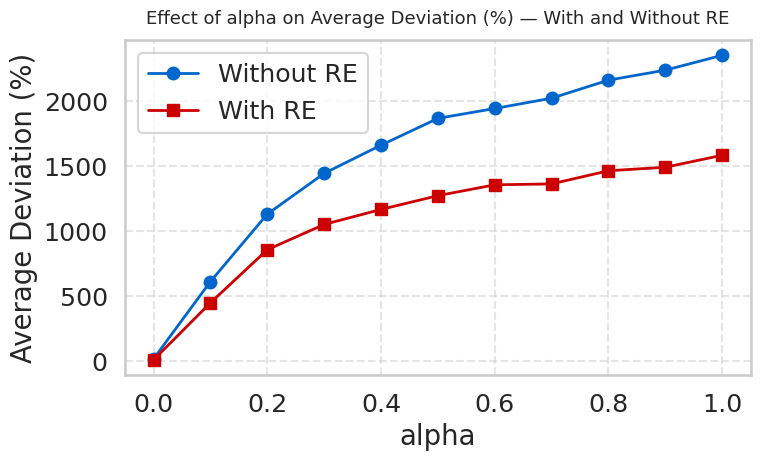

,alpha,avg_dev_noRE,avg_dev_RE
0,0.0,13.623,5.524
1,0.1,609.172,445.456
2,0.2,1128.824,854.463
3,0.3,1443.023,1049.145
4,0.4,1660.055,1164.872
5,0.5,1866.683,1271.139
6,0.6,1942.852,1354.593
7,0.7,2022.195,1361.636
8,0.8,2161.396,1462.934
9,0.9,2238.256,1489.889


In [62]:
# ============================================================
# 📈 Comparison: Impact of Alpha on Average Deviation (%)
# With and Without Redundancy Elimination (RE)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

alpha_values = np.arange(0.0, 1.05, 0.1)

avg_dev_noRE = []
avg_dev_RE = []

for alpha in alpha_values:
    # Without RE
    file_noRE = os.path.join("results", f"random_alpha={alpha:.2f}.csv")
    if os.path.exists(file_noRE):
        df_noRE = pd.read_csv(file_noRE)
        if "deviation_%" in df_noRE.columns:
            avg_dev_noRE.append(df_noRE["deviation_%"].mean())
        else:
            avg_dev_noRE.append(np.nan)
    else:
        avg_dev_noRE.append(np.nan)

    # With RE
    file_RE = os.path.join("results", f"random_RE_alpha={alpha:.2f}.csv")
    if os.path.exists(file_RE):
        df_RE = pd.read_csv(file_RE)
        if "deviation_%" in df_RE.columns:
            avg_dev_RE.append(df_RE["deviation_%"].mean())
        else:
            avg_dev_RE.append(np.nan)
    else:
        avg_dev_RE.append(np.nan)

# --- Plot the two lines (no shaded area) ---
plt.figure(figsize=(8,5))
plt.plot(alpha_values, avg_dev_noRE, label="Without RE", color="#0066cc", marker="o", linewidth=2)
plt.plot(alpha_values, avg_dev_RE, label="With RE", color="#cc0000", marker="s", linewidth=2)

plt.title("Effect of alpha on Average Deviation (%) — With and Without RE", fontsize=13, pad=12)
plt.xlabel(r"alpha")
plt.ylabel("Average Deviation (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Summary table ---
summary_df = pd.DataFrame({
    "alpha": alpha_values,
    "avg_dev_noRE": avg_dev_noRE,
    "avg_dev_RE": avg_dev_RE
})
display(summary_df.round(3))


# Greedy Cost Efficient : Effect of Local Search

In [6]:
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# ------------------------------------------------------
# 🔹 Load results
# ------------------------------------------------------
df_greedy_RE = load_results("greedy_RE.csv")
df_greedy_FI_drop_or_swap = load_results("greedy_FI_drop_or_swap.csv")
df_greedy_BI_drop_or_swap = load_results("greedy_BI_drop_or_swap.csv")

# ------------------------------------------------------
# 🔹 Merge on instance_name
# ------------------------------------------------------
merged = (
    df_greedy_RE[["instance_name", "solution_cost", "deviation_%"]]
        .rename(columns={"solution_cost": "cost_greedy_RE",
                         "deviation_%": "dev_greedy_RE"})
    .merge(
        df_greedy_FI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={"solution_cost": "cost_greedy_FI_drop_or_swap",
                             "deviation_%": "dev_greedy_FI_drop_or_swap"}),
        on="instance_name"
    )
    .merge(
        df_greedy_BI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={"solution_cost": "cost_greedy_BI_drop_or_swap",
                             "deviation_%": "dev_greedy_BI_drop_or_swap"}),
        on="instance_name"
    )
)

#display(merged.head())

# ------------------------------------------------------
# 🔹 Statistical Comparison Function
# ------------------------------------------------------
def compare_variants(df, col_ref, col_new, label):
    """
    Compare two algorithm variants statistically.
    Shows fraction of improvements, average improvement %, and significance tests.
    """
    # Drop missing data for fairness
    df = df.dropna(subset=[col_ref, col_new])

    x = df[col_ref].values
    y = df[col_new].values

    diff = y - x
    rel_diff = diff / x * 100  # % difference relative to baseline

    improved = (diff < 0).mean()
    equal = (diff == 0).mean()
    worse = (diff > 0).mean()

    # Global average improvement (negative means lower cost)
    avg_rel_improv_all = -rel_diff.mean()  # positive = improvement

    # ✅ Student's paired t-test
    t_stat, t_p = ttest_rel(x, y)

    # ✅ Wilcoxon signed-rank test (robust, nonparametric)
    try:
        w_stat, w_p = wilcoxon(x, y)
    except ValueError:
        w_stat, w_p = np.nan, np.nan  # happens if all diffs == 0

    print(f"\n🔸 {label}:")
    print(f"  → Improved: {improved:.2%}")
    print(f"  → Equal:    {equal:.2%}")
    print(f"  → Worse:    {worse:.2%}")
    print(f"  → Avg. % improvement (overall): {avg_rel_improv_all:.2f}%")
    print(f"  → t-test p-value:       {t_p:.4f} ({'significant ✅' if t_p < 0.05 else 'ns'})")
    print(f"  → Wilcoxon p-value:     {w_p:.4f} ({'significant ✅' if w_p < 0.05 else 'ns'})")

# ------------------------------------------------------
# 🔹 Run detailed comparisons
# ------------------------------------------------------
print("🔹 Detailed Comparison vs Greedy+RE:")
compare_variants(merged, "cost_greedy_RE",
                 "cost_greedy_FI_drop_or_swap",
                 "Greedy+RE → +FI_drop_or_swap")

compare_variants(merged, "cost_greedy_RE",
                 "cost_greedy_BI_drop_or_swap",
                 "Greedy+RE → +BI_drop_or_swap")



Results summary for 'greedy_RE.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.47%
   Average deviation: +5.52%
   Worst deviation:  +15.53%
   Instances reaching best-known solution: 0 / 42

Computation time:
   Total runtime: 0 h 0 m 25 s
   Average per instance: 0.60 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'greedy_FI_drop_or_swap.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.47%
   Average deviation: +5.00%
   Worst deviation:  +13.33%
   Instances reaching best-known solution: 0 / 42

Computation time:
   Total runtime: 0 h 2 m 23 s
   Average per instance: 3.42 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'greedy_BI_d

# Greedy Cost Squared : Effect of Local Search

In [ ]:
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# ------------------------------------------------------
# 🔹 Load results for SQUARED
# ------------------------------------------------------
df_squared_RE = load_results("squared_RE.csv")
df_squared_FI_drop_or_swap = load_results("squared_FI_drop_or_swap.csv")
df_squared_BI_drop_or_swap = load_results("squared_BI_drop_or_swap.csv")

# ------------------------------------------------------
# 🔹 Merge all three on instance_name
# ------------------------------------------------------
merged_squared = (
    df_squared_RE[["instance_name", "solution_cost", "deviation_%"]]
        .rename(columns={"solution_cost": "cost_squared_RE",
                         "deviation_%": "dev_squared_RE"})
    .merge(
        df_squared_FI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={"solution_cost": "cost_squared_FI_drop_or_swap",
                             "deviation_%": "dev_squared_FI_drop_or_swap"}),
        on="instance_name"
    )
    .merge(
        df_squared_BI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={"solution_cost": "cost_squared_BI_drop_or_swap",
                             "deviation_%": "dev_squared_BI_drop_or_swap"}),
        on="instance_name"
    )
)

#display(merged_squared.head())

# ------------------------------------------------------
# 🔹 Statistical Comparison Function
# ------------------------------------------------------
def compare_variants(df, col_ref, col_new, label):
    """
    Compare two algorithm variants statistically.
    Shows fraction of improvements, average improvement %, and significance tests.
    """
    # Drop missing data for fairness
    df = df.dropna(subset=[col_ref, col_new])

    x = df[col_ref].values
    y = df[col_new].values

    diff = y - x
    rel_diff = diff / x * 100  # % difference relative to baseline

    improved = (diff < 0).mean()
    equal = (diff == 0).mean()
    worse = (diff > 0).mean()

    avg_rel_improv_all = -rel_diff.mean()  # positive = overall improvement

    # ✅ Student's paired t-test
    t_stat, t_p = ttest_rel(x, y)

    # ✅ Wilcoxon signed-rank test (robust nonparametric)
    try:
        w_stat, w_p = wilcoxon(x, y)
    except ValueError:
        w_stat, w_p = np.nan, np.nan  # happens if all diffs == 0

    print(f"\n🔸 {label}:")
    print(f"  → Improved: {improved:.2%}")
    print(f"  → Equal:    {equal:.2%}")
    print(f"  → Worse:    {worse:.2%}")
    print(f"  → Avg. % improvement (overall): {avg_rel_improv_all:.2f}%")
    print(f"  → t-test p-value:       {t_p:.4f} ({'significant ✅' if t_p < 0.05 else 'ns'})")
    print(f"  → Wilcoxon p-value:     {w_p:.4f} ({'significant ✅' if w_p < 0.05 else 'ns'})")

# ------------------------------------------------------
# 🔹 Run detailed comparisons
# ------------------------------------------------------
print("🔹 Detailed Comparison vs Squared+RE:")
compare_variants(merged_squared,
                 "cost_squared_RE",
                 "cost_squared_FI_drop_or_swap",
                 "Squared+RE → +FI_drop_or_swap")

compare_variants(merged_squared,
                 "cost_squared_RE",
                 "cost_squared_BI_drop_or_swap",
                 "Squared+RE → +BI_drop_or_swap")



Results summary for 'squared_RE.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.00%
   Average deviation: +7.51%
   Worst deviation:  +18.01%
   Instances reaching best-known solution: 1 / 42

Computation time:
   Total runtime: 0 h 0 m 29 s
   Average per instance: 0.71 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'squared_FI_drop_or_swap.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +1.39%
   Average deviation: +6.95%
   Worst deviation:  +14.49%
   Instances reaching best-known solution: 0 / 42

Computation time:
   Total runtime: 0 h 3 m 20 s
   Average per instance: 4.77 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'squared_B

# Randomized : Effect of Local Search


In [10]:
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# ------------------------------------------------------
# 🔹 Load results for RANDOMIZED
# ------------------------------------------------------
df_randomized_RE = load_results("randomized_RE.csv")
df_randomized_FI_drop_or_swap = load_results("randomized_FI_drop_or_swap.csv")
df_randomized_BI_drop_or_swap = load_results("randomiz_paralleled_BI_drop_or_swap.csv")

# ------------------------------------------------------
# 🔹 Merge all three on instance_name
# ------------------------------------------------------
merged_randomized = (
    df_randomized_RE[["instance_name", "solution_cost", "deviation_%"]]
        .rename(columns={
            "solution_cost": "cost_randomized_RE",
            "deviation_%": "dev_randomized_RE"
        })
    .merge(
        df_randomized_FI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={
                "solution_cost": "cost_randomized_FI_drop_or_swap",
                "deviation_%": "dev_randomized_FI_drop_or_swap"
            }),
        on="instance_name"
    )
    .merge(
        df_randomized_BI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={
                "solution_cost": "cost_randomized_BI_drop_or_swap",
                "deviation_%": "dev_randomized_BI_drop_or_swap"
            }),
        on="instance_name"
    )
)

#display(merged_randomized.head())

# ------------------------------------------------------
# 🔹 Statistical Comparison Function
# ------------------------------------------------------
def compare_variants(df, col_ref, col_new, label):
    """
    Compare two algorithm variants statistically.
    Shows fraction of improvements, average improvement %, and significance tests.
    """
    # Drop missing data for fairness
    df = df.dropna(subset=[col_ref, col_new])

    x = df[col_ref].values
    y = df[col_new].values

    diff = y - x
    rel_diff = diff / x * 100  # % difference relative to baseline

    improved = (diff < 0).mean()
    equal = (diff == 0).mean()
    worse = (diff > 0).mean()

    avg_rel_improv_all = -rel_diff.mean()  # positive = overall improvement

    # ✅ Student's paired t-test
    t_stat, t_p = ttest_rel(x, y)

    # ✅ Wilcoxon signed-rank test (robust nonparametric)
    try:
        w_stat, w_p = wilcoxon(x, y)
    except ValueError:
        w_stat, w_p = np.nan, np.nan  # happens if all diffs == 0

    print(f"\n🔸 {label}:")
    print(f"  → Improved: {improved:.2%}")
    print(f"  → Equal:    {equal:.2%}")
    print(f"  → Worse:    {worse:.2%}")
    print(f"  → Avg. % improvement (overall): {avg_rel_improv_all:.2f}%")
    print(f"  → t-test p-value:       {t_p:.4f} ({'significant ✅' if t_p < 0.05 else 'ns'})")
    print(f"  → Wilcoxon p-value:     {w_p:.4f} ({'significant ✅' if w_p < 0.05 else 'ns'})")

# ------------------------------------------------------
# 🔹 Run detailed comparisons
# ------------------------------------------------------
print("🔹 Detailed Comparison vs Randomized+RE:")
compare_variants(
    merged_randomized,
    "cost_randomized_RE",
    "cost_randomized_FI_drop_or_swap",
    "Randomized+RE → +FI_drop_or_swap"
)

compare_variants(
    merged_randomized,
    "cost_randomized_RE",
    "cost_randomized_BI_drop_or_swap",
    "Randomized+RE → +BI_drop_or_swap"
)



Results summary for 'randomized_RE.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +1.02%
   Average deviation: +10.73%
   Worst deviation:  +41.67%
   Instances reaching best-known solution: 0 / 42

Computation time:
   Total runtime: 0 h 0 m 29 s
   Average per instance: 0.69 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'randomized_FI_drop_or_swap.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.20%
   Average deviation: +6.72%
   Worst deviation:  +22.95%
   Instances reaching best-known solution: 0 / 42

Computation time:
   Total runtime: 0 h 3 m 13 s
   Average per instance: 4.61 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'ra

# RE before FI and BI

In [9]:
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# ------------------------------------------------------
# 🔹 Load results for GREEDY → RE → LocalSearch
# ------------------------------------------------------
df_greedy_RE = load_results("greedy_RE.csv")
df_greedy_RE_FI_drop_or_swap = load_results("greedy_RE_FI_drop_or_swap.csv")
df_greedy_RE_BI_drop_or_swap = load_results("greedy_RE_BI_drop_or_swap.csv")

# ------------------------------------------------------
# 🔹 Merge all three on instance_name
# ------------------------------------------------------
merged_greedy_RE_pipeline = (
    df_greedy_RE[["instance_name", "solution_cost", "deviation_%"]]
        .rename(columns={
            "solution_cost": "cost_greedy_RE",
            "deviation_%": "dev_greedy_RE"
        })
    .merge(
        df_greedy_RE_FI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={
                "solution_cost": "cost_greedy_RE_FI_drop_or_swap",
                "deviation_%": "dev_greedy_RE_FI_drop_or_swap"
            }),
        on="instance_name"
    )
    .merge(
        df_greedy_RE_BI_drop_or_swap[["instance_name", "solution_cost", "deviation_%"]]
            .rename(columns={
                "solution_cost": "cost_greedy_RE_BI_drop_or_swap",
                "deviation_%": "dev_greedy_RE_BI_drop_or_swap"
            }),
        on="instance_name"
    )
)

#display(merged_greedy_RE_pipeline.head())

# ------------------------------------------------------
# 🔹 Statistical Comparison Function
# ------------------------------------------------------
def compare_variants(df, col_ref, col_new, label):
    """
    Compare two algorithm variants statistically.
    Shows fraction of improvements, average improvement %, and significance tests.
    """
    # Drop missing data for fairness
    df = df.dropna(subset=[col_ref, col_new])

    x = df[col_ref].values
    y = df[col_new].values

    diff = y - x
    rel_diff = diff / x * 100  # % difference relative to baseline

    improved = (diff < 0).mean()
    equal = (diff == 0).mean()
    worse = (diff > 0).mean()

    avg_rel_improv_all = -rel_diff.mean()  # positive = overall improvement

    # ✅ Student's paired t-test
    t_stat, t_p = ttest_rel(x, y)

    # ✅ Wilcoxon signed-rank test (robust nonparametric)
    try:
        w_stat, w_p = wilcoxon(x, y)
    except ValueError:
        w_stat, w_p = np.nan, np.nan  # happens if all diffs == 0

    print(f"\n🔸 {label}:")
    print(f"  → Improved: {improved:.2%}")
    print(f"  → Equal:    {equal:.2%}")
    print(f"  → Worse:    {worse:.2%}")
    print(f"  → Avg. % improvement (overall): {avg_rel_improv_all:.2f}%")
    print(f"  → t-test p-value:       {t_p:.4f} ({'significant ✅' if t_p < 0.05 else 'ns'})")
    print(f"  → Wilcoxon p-value:     {w_p:.4f} ({'significant ✅' if w_p < 0.05 else 'ns'})")

# ------------------------------------------------------
# 🔹 Run detailed comparisons
# ------------------------------------------------------
print("🔹 Detailed Comparison vs Greedy+RE:")
compare_variants(
    merged_greedy_RE_pipeline,
    "cost_greedy_RE",
    "cost_greedy_RE_FI_drop_or_swap",
    "Greedy+RE → +FI_drop_or_swap"
)

compare_variants(
    merged_greedy_RE_pipeline,
    "cost_greedy_RE",
    "cost_greedy_RE_BI_drop_or_swap",
    "Greedy+RE → +BI_drop_or_swap"
)



Results summary for 'greedy_RE.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.47%
   Average deviation: +5.52%
   Worst deviation:  +15.53%
   Instances reaching best-known solution: 0 / 42

Computation time:
   Total runtime: 0 h 0 m 25 s
   Average per instance: 0.60 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'greedy_RE_FI_drop_or_swap.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.47%
   Average deviation: +4.95%
   Worst deviation:  +13.33%
   Instances reaching best-known solution: 0 / 42

Computation time:
   Total runtime: 0 h 1 m 21 s
   Average per instance: 1.94 s

All solution costs verified successfully.
----------------------------------------------------------------------

Results summary for 'greedy_R

# GRASP
## Vanilla GRASP for different alphas and instance sizes

In [38]:
import pandas as pd
import numpy as np
import os

def summarize_by_size(csv_files, results_folder="results", instances_folder="SCP-Instances"):
    """
    Compare multiple GRASP (or other) algorithm results over small vs. large SCP instances.

    Each CSV corresponds to a different algorithm configuration.
    Outputs one row per algorithm, with separate columns for Small and Large instances.
    """
    from SCPDefinitions import SCPInstance

    # --- Load instance dimensions (m, n) ---
    files = sorted(
        [f for f in os.listdir(instances_folder)
         if f.lower().startswith("scp") and f.endswith(".txt")]
    )

    inst_info = {}
    for i, fname in enumerate(files):
        inst = SCPInstance(i, folder=instances_folder)
        inst_info[inst.name] = {"m": inst.m, "n": inst.n}

    summary_rows = []

    # --- Iterate over all algorithms (CSV files) ---
    for csv_name in csv_files:
        csv_path = os.path.join(results_folder, csv_name)
        if not os.path.exists(csv_path):
            print(f"⚠️ Missing: {csv_name}")
            continue

        df = pd.read_csv(csv_path)
        if "deviation_%" not in df:
            print(f"⚠️ No deviation column in {csv_name}")
            continue

        # Attach instance sizes
        df["m"] = df["instance_name"].map(lambda x: inst_info.get(x, {}).get("m", None))
        df["n"] = df["instance_name"].map(lambda x: inst_info.get(x, {}).get("n", None))

        # ✅ Correct: n = sets, m = attributes
        df["size_group"] = np.where((df["m"] < 300), "Small", "Large")

        # Compute averages
        grouped = (
            df.groupby("size_group")[["deviation_%", "time_sec"]]
            .mean()
            .rename(columns={"deviation_%": "Avg. Deviation (%)", "time_sec": "Avg. Time (s)"})
        )

        algo_name = csv_name.replace(".csv", "")
        small_dev = grouped.loc["Small", "Avg. Deviation (%)"] if "Small" in grouped.index else np.nan
        large_dev = grouped.loc["Large", "Avg. Deviation (%)"] if "Large" in grouped.index else np.nan
        small_time = grouped.loc["Small", "Avg. Time (s)"] if "Small" in grouped.index else np.nan
        large_time = grouped.loc["Large", "Avg. Time (s)"] if "Large" in grouped.index else np.nan

        summary_rows.append({
            "Algorithm": algo_name,
            "Small Dev (%)": small_dev,
            "Large Dev (%)": large_dev,
            "Small Time (s)": small_time,
            "Large Time (s)": large_time
        })

    summary_df = pd.DataFrame(summary_rows).round(2)
    print("\n=== Results by Instance Size ===")
    print(summary_df.to_string(index=False))
    return summary_df


# Example usage
csv_files = [
    "grasp_5min_alpha_0.000.csv",
    "grasp_5min_alpha_0.010.csv",
    "grasp_5min_alpha_0.025.csv",
    #"grasp_5min_alpha_0.050.csv",
]

summary_df = summarize_by_size(csv_files)



=== Results by Instance Size ===
             Algorithm  Small Dev (%)  Large Dev (%)  Small Time (s)  Large Time (s)
grasp_5min_alpha_0.000           4.26           4.89          300.42          301.34
grasp_5min_alpha_0.010           1.88           2.65          300.36          301.29
grasp_5min_alpha_0.025           2.24           6.68          300.41          301.84


In [ ]:
import pandas as pd
import numpy as np
import os

def summarize_by_size(csv_files, results_folder="results", instances_folder="SCP-Instances"):
    """
    Compare multiple GRASP (or other) algorithm results over small vs. large SCP instances.

    Each CSV corresponds to a different algorithm configuration.
    Outputs one row per algorithm, with separate columns for Small and Large instances.
    """
    from SCPDefinitions import SCPInstance

    # --- Load instance dimensions (m, n) ---
    files = sorted(
        [f for f in os.listdir(instances_folder)
         if f.lower().startswith("scp") and f.endswith(".txt")]
    )

    inst_info = {}
    for i, fname in enumerate(files):
        inst = SCPInstance(i, folder=instances_folder)
        inst_info[inst.name] = {"m": inst.m, "n": inst.n}

    summary_rows = []

    # --- Iterate over all algorithms (CSV files) ---
    for csv_name in csv_files:
        csv_path = os.path.join(results_folder, csv_name)
        if not os.path.exists(csv_path):
            print(f"⚠️ Missing: {csv_name}")
            continue

        df = pd.read_csv(csv_path)
        if "deviation_%" not in df:
            print(f"⚠️ No deviation column in {csv_name}")
            continue

        # Attach instance sizes
        df["m"] = df["instance_name"].map(lambda x: inst_info.get(x, {}).get("m", None))
        df["n"] = df["instance_name"].map(lambda x: inst_info.get(x, {}).get("n", None))

        # ✅ Correct: n = sets, m = attributes
        df["size_group"] = np.where((df["m"] < 300), "Small", "Large")

        # Compute averages
        grouped = (
            df.groupby("size_group")[["deviation_%", "time_sec"]]
            .mean()
            .rename(columns={"deviation_%": "Avg. Deviation (%)", "time_sec": "Avg. Time (s)"})
        )

        algo_name = csv_name.replace(".csv", "")
        small_dev = grouped.loc["Small", "Avg. Deviation (%)"] if "Small" in grouped.index else np.nan
        large_dev = grouped.loc["Large", "Avg. Deviation (%)"] if "Large" in grouped.index else np.nan
        small_time = grouped.loc["Small", "Avg. Time (s)"] if "Small" in grouped.index else np.nan
        large_time = grouped.loc["Large", "Avg. Time (s)"] if "Large" in grouped.index else np.nan

        summary_rows.append({
            "Algorithm": algo_name,
            "Small Dev (%)": small_dev,
            "Large Dev (%)": large_dev,
            "Small Time (s)": small_time,
            "Large Time (s)": large_time
        })

    summary_df = pd.DataFrame(summary_rows).round(2)
    print("\n=== Results by Instance Size ===")
    print(summary_df.to_string(index=False))
    return summary_df


# Example usage
csv_files = [
    "grasp_5min_alpha_0.000.csv",
    "grasp_5min_alpha_0.010.csv",
    "grasp_5min_alpha_0.025.csv",
    #"grasp_5min_alpha_0.050.csv",
]

summary_df = summarize_by_size(csv_files)



=== Results by Instance Size ===
             Algorithm  Small Dev (%)  Large Dev (%)  Small Time (s)  Large Time (s)
grasp_5min_alpha_0.000           3.02           2.48          300.45          301.25
grasp_5min_alpha_0.010           3.02           2.40          300.48          301.28
grasp_5min_alpha_0.025           3.04           2.55          300.52          301.66


In [17]:
df_GRASP_parallel = load_results("grasp_parallel_fixed_RCL.csv")



Results summary for 'grasp_parallel_fixed_RCL.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.00%
   Average deviation: +2.53%
   Worst deviation:  +10.53%
   Instances reaching best-known solution: 2 / 42

Computation time:
   Total runtime: 0 h 58 m 55 s
   Average per instance: 84.17 s

All solution costs verified successfully.
----------------------------------------------------------------------


# TABU

In [3]:
df_RTABU = load_results("reactive_tabu_whole_night.csv")


Results summary for 'reactive_tabu_whole_night.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.00%
   Average deviation: +1.26%
   Worst deviation:  +4.17%
   Instances reaching best-known solution: 10 / 42

Computation time:
   Total runtime: 72 h 0 m 37 s
   Average per instance: 6172.32 s

All solution costs verified successfully.
----------------------------------------------------------------------


In [ ]:
df_RTABU = load_results("reactive_tabu_whole_night.csv")


Results summary for 'reactive_tabu_whole_night.csv'
----------------------------------------------------------------------
Deviation from best-known solutions:
   Best deviation:   +0.00%
   Average deviation: +1.26%
   Worst deviation:  +4.17%
   Instances reaching best-known solution: 10 / 42

Computation time:
   Total runtime: 72 h 0 m 37 s
   Average per instance: 6172.32 s

All solution costs verified successfully.
----------------------------------------------------------------------
